In [28]:
#!pip install imblearn
import warnings
warnings.filterwarnings('ignore')

In [29]:
from pymongo import MongoClient
import pandas as pd

import numpy as np
from scipy import interp
from scipy.stats import ttest_1samp, wilcoxon, mannwhitneyu

import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.utils.fixes import signature

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import ClusterCentroids, NearMiss
from imblearn.metrics import classification_report_imbalanced

In [3]:
conn = MongoClient('140.115.53.147', 27017)
conn.database_names()

/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: database_names is deprecated. Use list_database_names instead.
  


['107_ELK',
 'AU_106_2_BIO',
 'AU_106_2_SE',
 'CYCU_1031SP',
 'CYCU_1041SP',
 'CYCU_1042OS',
 'CYCU_1051SP',
 'CYCU_1052OS',
 'KU_dataset_1',
 'KU_dataset_2',
 'NCU_1071MATH',
 'NCU_CHKA',
 'NCU_CHKB',
 'NCU_ETS',
 'NCUx107_Pre_college_calculas',
 'OULAD',
 'admin',
 'config',
 'local',
 'test']

In [36]:
datasets = 'NCUx107_Pre_college_calculas'
db = conn[datasets]
collection = db['students_grades']
score_df = pd.DataFrame(list(collection.find()))
score_df = score_df.drop(['_id'], axis=1)
score_df = score_df[['studentId', 'finalScore']]
score_df = score_df.rename(index=str, columns={"studentId": "username"})
score_df.head(5)

,username,finalScore
0,107203516,82
1,107202510,82
2,107202506,64
3,107203518,72
4,107206504,77


In [37]:
db = conn[datasets]
collection = db['ma_w8.csv']
feature_df = pd.DataFrame(list(collection.find()))

feature_df = feature_df.drop(['_id'], axis=1)
feature_df = feature_df.drop(['email'], axis=1)
feature_df = feature_df.drop(['label'], axis=1)
feature_df = feature_df.drop(['course_id'], axis=1)

feature_df = feature_df.fillna('0')
feature_df.head(5)

,active_avg_count,active_num_days,active_sum_count,all_type_video_backward_seek_avg,all_type_video_backward_seek_sum,all_type_video_forward_seek_avg,all_type_video_forward_seek_sum,all_type_video_seek_avg,all_type_video_seek_sum,complete_rate,...,video_play_avg,video_play_sum,video_stop_avg,video_stop_backward_seek_avg,video_stop_backward_seek_sum,video_stop_sum,video_sum_count,watched_time_hour,watched_time_weekday,week
0,20.000000,1,20,0.000000,0,0.000000,0,0.000000,0,0.000000,...,0.000000,0,0.000000,0.000000,0,0,1,0.000000,0,3
1,2.000000,1,2,0.000000,0,0.000000,0,0.000000,0,0.000000,...,0.000000,0,0.000000,0.000000,0,0,0,0.000000,0,5
2,14.000000,1,14,0.000000,0,0.000000,0,0.000000,0,0.000000,...,0.000000,0,0.000000,0.000000,0,0,0,0.000000,0,-1
3,272.000000,3,816,2.250000,27,3.250000,39,5.500000,66,0.916667,...,6.500000,78,0.416667,0.083333,1,5,85,8.101351,7,0
4,104.666667,3,314,1.428571,10,1.428571,10,2.857143,20,0.571429,...,3.857143,27,0.000000,0.000000,0,0,29,11.969146,1,1


In [32]:
ncu_ets = pd.merge(feature_df, score_df, on='username')
ncu_ets = ncu_ets.drop(['username'], axis=1)
ncu_ets = ncu_ets.drop(['week'], axis=1)
ncu_ets = ncu_ets.astype(float)
ncu_ets['class'] = ncu_ets['finalScore'] < 60
ncu_ets = ncu_ets.drop(['finalScore'], axis=1)
ncu_ets.head(5)

,active_avg_count,active_num_days,active_sum_count,all_type_video_backward_seek_avg,all_type_video_backward_seek_sum,all_type_video_forward_seek_avg,all_type_video_forward_seek_sum,all_type_video_seek_avg,all_type_video_seek_sum,complete_rate,...,video_play_avg,video_play_sum,video_stop_avg,video_stop_backward_seek_avg,video_stop_backward_seek_sum,video_stop_sum,video_sum_count,watched_time_hour,watched_time_weekday,class
0,96.000000,1.0,96.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,True
1,36.000000,1.0,36.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,True
2,122.333333,6.0,734.0,1.500000,6.0,6.000000,24.0,7.500000,30.0,0.500000,...,8.500000,34.0,0.000000,0.0,0.0,0.0,36.0,15.174407,2.0,False
3,243.857143,7.0,1707.0,1.076923,14.0,4.153846,54.0,5.230769,68.0,0.538462,...,6.230769,81.0,0.076923,0.0,0.0,1.0,99.0,2.122340,7.0,False
4,139.000000,7.0,973.0,2.300000,23.0,2.900000,29.0,5.200000,52.0,0.400000,...,6.200000,62.0,0.300000,0.2,2.0,3.0,52.0,1.845016,7.0,False


In [33]:
X = ncu_ets.drop(['class'], axis=1)
X = X.values
y = ncu_ets['class']

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=5)

clf_binary = svm.SVC(kernel='rbf', 
                     probability=True,
                     cache_size=700,
                     random_state=5,
                     gamma='scale')

clf_one = svm.OneClassSVM(kernel="rbf",
                         cache_size=700,
                         random_state=5,
                         gamma='scale')


In [34]:
def compute_roc (X, y, title):
    
    tprs = []
    aucs = []
    #acc = []
    mean_fpr = np.linspace(0, 1, 100)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    #fig, ax1 = plt.su
    
    i = 0
    for train, test in cv.split(X, y):

        y_pred = clf_binary.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], y_pred[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        acc = accuracy_score(y[test], y_pred[:, 1].round())
        precision, recall, _ = precision_recall_curve(y[test], y_pred[:, 1])
        average_precision = average_precision_score(y[test], y_pred[:, 1])
        #accs.append(accuracy_score(y[test], y_pred[:, 1].round()))
        ax1.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f, ACC = %0.2f)' % (i, roc_auc, acc))

        i += 1
    ax1.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax1.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax1.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    ax1.set_xlim([-0.05, 1.05])
    ax1.set_ylim([-0.05, 1.05])
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('Receiver operating characteristic of '+ title)
    ax1.legend(loc="lower right")
    
    
    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
    ax2.step(recall, precision, color='b', alpha=0.2, where='post')
    ax2.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlim([0.0, 1.0])
    ax2.set_title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
    
    image_name = './images/' + datasets + '_' + title + '.png'
    fig.savefig(image_name, dpi=300)
    
    return aucs

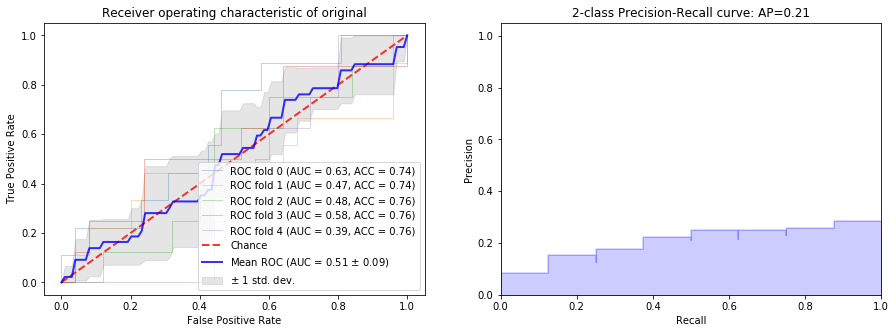

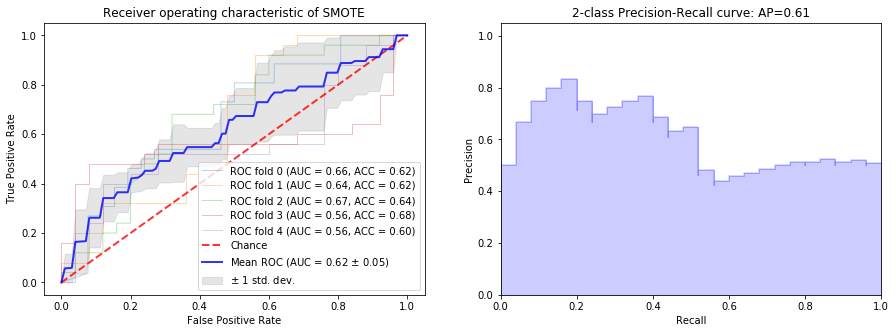

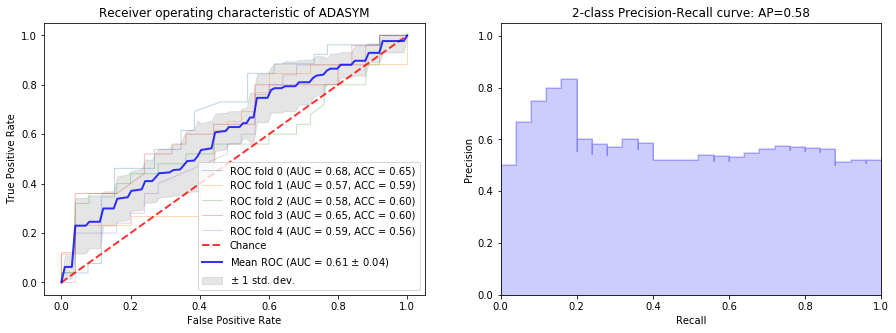

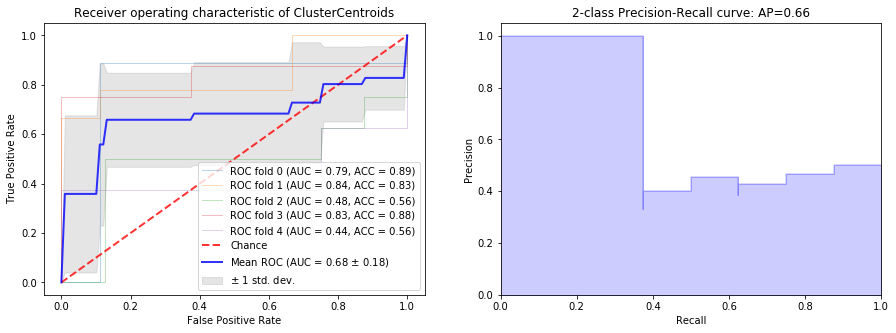

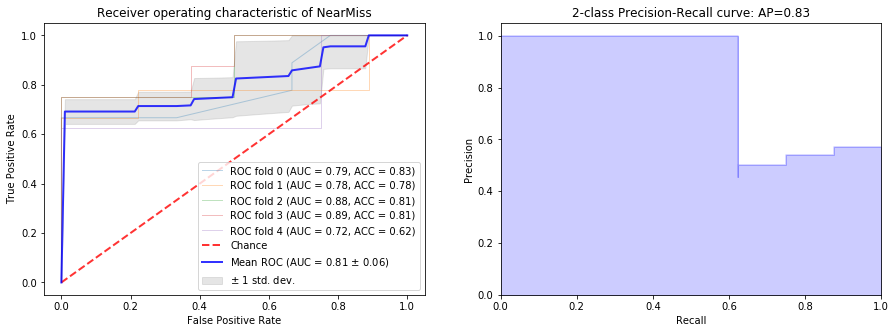

In [38]:
auc_ori = compute_roc(X, y, title='original')

res_X, res_y = SMOTE(ratio = 1.0).fit_sample(X, y)
auc_sm = compute_roc(res_X, res_y, title='SMOTE')

res_X, res_y = ADASYN(ratio = 1.0).fit_sample(X, y)
auc_ada = compute_roc(res_X, res_y, title='ADASYM')

res_X, res_y = ClusterCentroids(random_state=0).fit_sample(X, y)
auc_cc = compute_roc(res_X, res_y, title='ClusterCentroids')

res_X, res_y = NearMiss(random_state=0).fit_sample(X, y)
auc_nm = compute_roc(res_X, res_y, title='NearMiss')

In [39]:
u, p_value = mannwhitneyu(auc_ori, auc_sm)
print ("two-sample wilcoxon-test", p_value)

u, p_value = mannwhitneyu(auc_ori, auc_ada)
print ("two-sample wilcoxon-test", p_value)

u, p_value = mannwhitneyu(auc_ori, auc_cc)
print ("two-sample wilcoxon-test", p_value)

u, p_value = mannwhitneyu(auc_ori, auc_nm)
print ("two-sample wilcoxon-test", p_value)

two-sample wilcoxon-test 0.047346471299737944
two-sample wilcoxon-test 0.07183604090348011
two-sample wilcoxon-test 0.10503752039332925
two-sample wilcoxon-test 0.006092890177672406


In [40]:
y_pred = clf_binary.fit(X, y).predict_proba(X)

res_X, res_y = SMOTE(ratio = 1.0).fit_sample(X, y)
y_pred_res = clf_binary.fit(res_X, res_y).predict_proba(X)

In [41]:
temp_pd = ncu_ets
temp_pd['original'] = y_pred[:, 1].round()
temp_pd['smote'] = y_pred_res[:, 1].round()
temp_pd.head(5)

,active_avg_count,active_num_days,active_sum_count,all_type_video_backward_seek_avg,all_type_video_backward_seek_sum,all_type_video_forward_seek_avg,all_type_video_forward_seek_sum,all_type_video_seek_avg,all_type_video_seek_sum,complete_rate,...,video_stop_avg,video_stop_backward_seek_avg,video_stop_backward_seek_sum,video_stop_sum,video_sum_count,watched_time_hour,watched_time_weekday,class,original,smote
0,96.000000,1.0,96.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,True,0.0,1.0
1,36.000000,1.0,36.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,True,0.0,1.0
2,122.333333,6.0,734.0,1.500000,6.0,6.000000,24.0,7.500000,30.0,0.500000,...,0.000000,0.0,0.0,0.0,36.0,15.174407,2.0,False,0.0,0.0
3,243.857143,7.0,1707.0,1.076923,14.0,4.153846,54.0,5.230769,68.0,0.538462,...,0.076923,0.0,0.0,1.0,99.0,2.122340,7.0,False,0.0,0.0
4,139.000000,7.0,973.0,2.300000,23.0,2.900000,29.0,5.200000,52.0,0.400000,...,0.300000,0.2,2.0,3.0,52.0,1.845016,7.0,False,0.0,0.0


In [42]:
origin_pd = temp_pd.ix[(temp_pd['class']==True) & (temp_pd['original'] == 0.0) & (temp_pd['smote'] == 0.0)]
smote_pd = temp_pd.ix[(temp_pd['class']==True) & (temp_pd['original'] == 0.0) & (temp_pd['smote'] == 1.0)]

<Figure size 1080x1080 with 0 Axes>

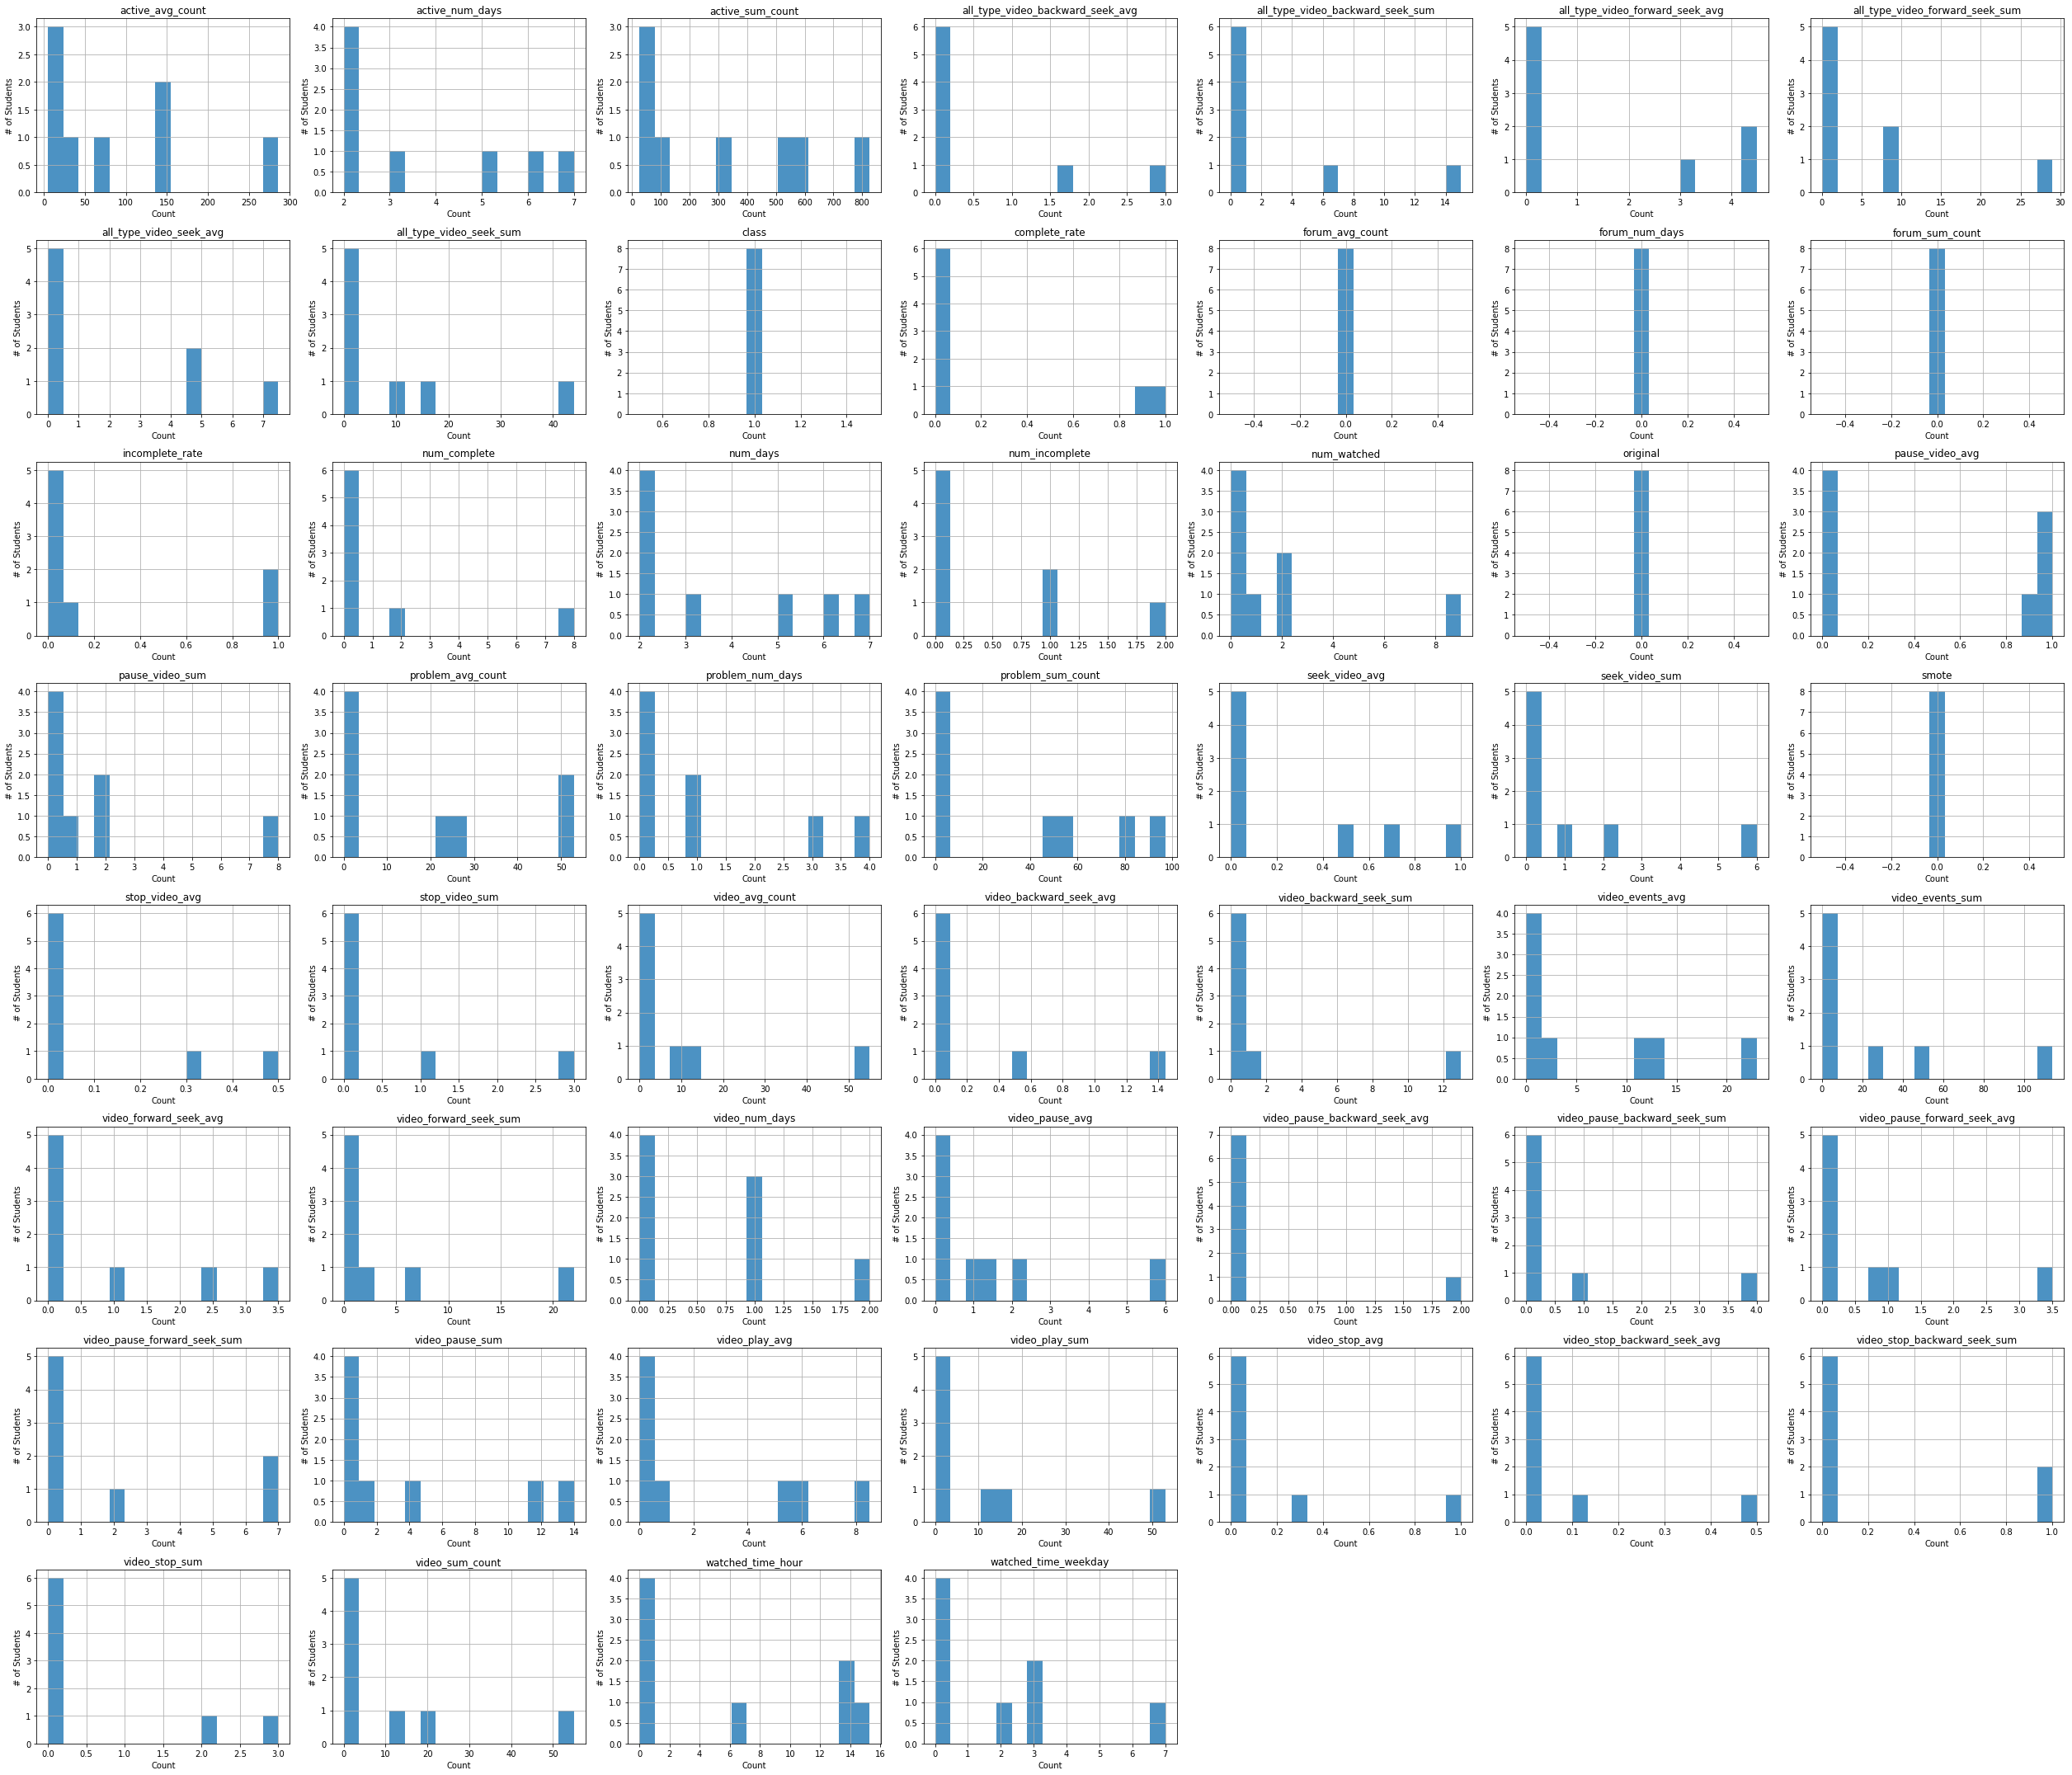

In [47]:
plt.figure(figsize=(15, 15))
ax = origin_pd.hist(alpha=0.8, bins=15, figsize=(35, 30))

for array in ax:
    for subplot in array:
        subplot.set_ylabel('# of Students')
        subplot.set_xlabel('Count')

plt.tight_layout()
image_name = './images/' + datasets + '_' + 'fc_original' + '.png'
plt.savefig(image_name, dpi=300)

<Figure size 2520x2520 with 0 Axes>

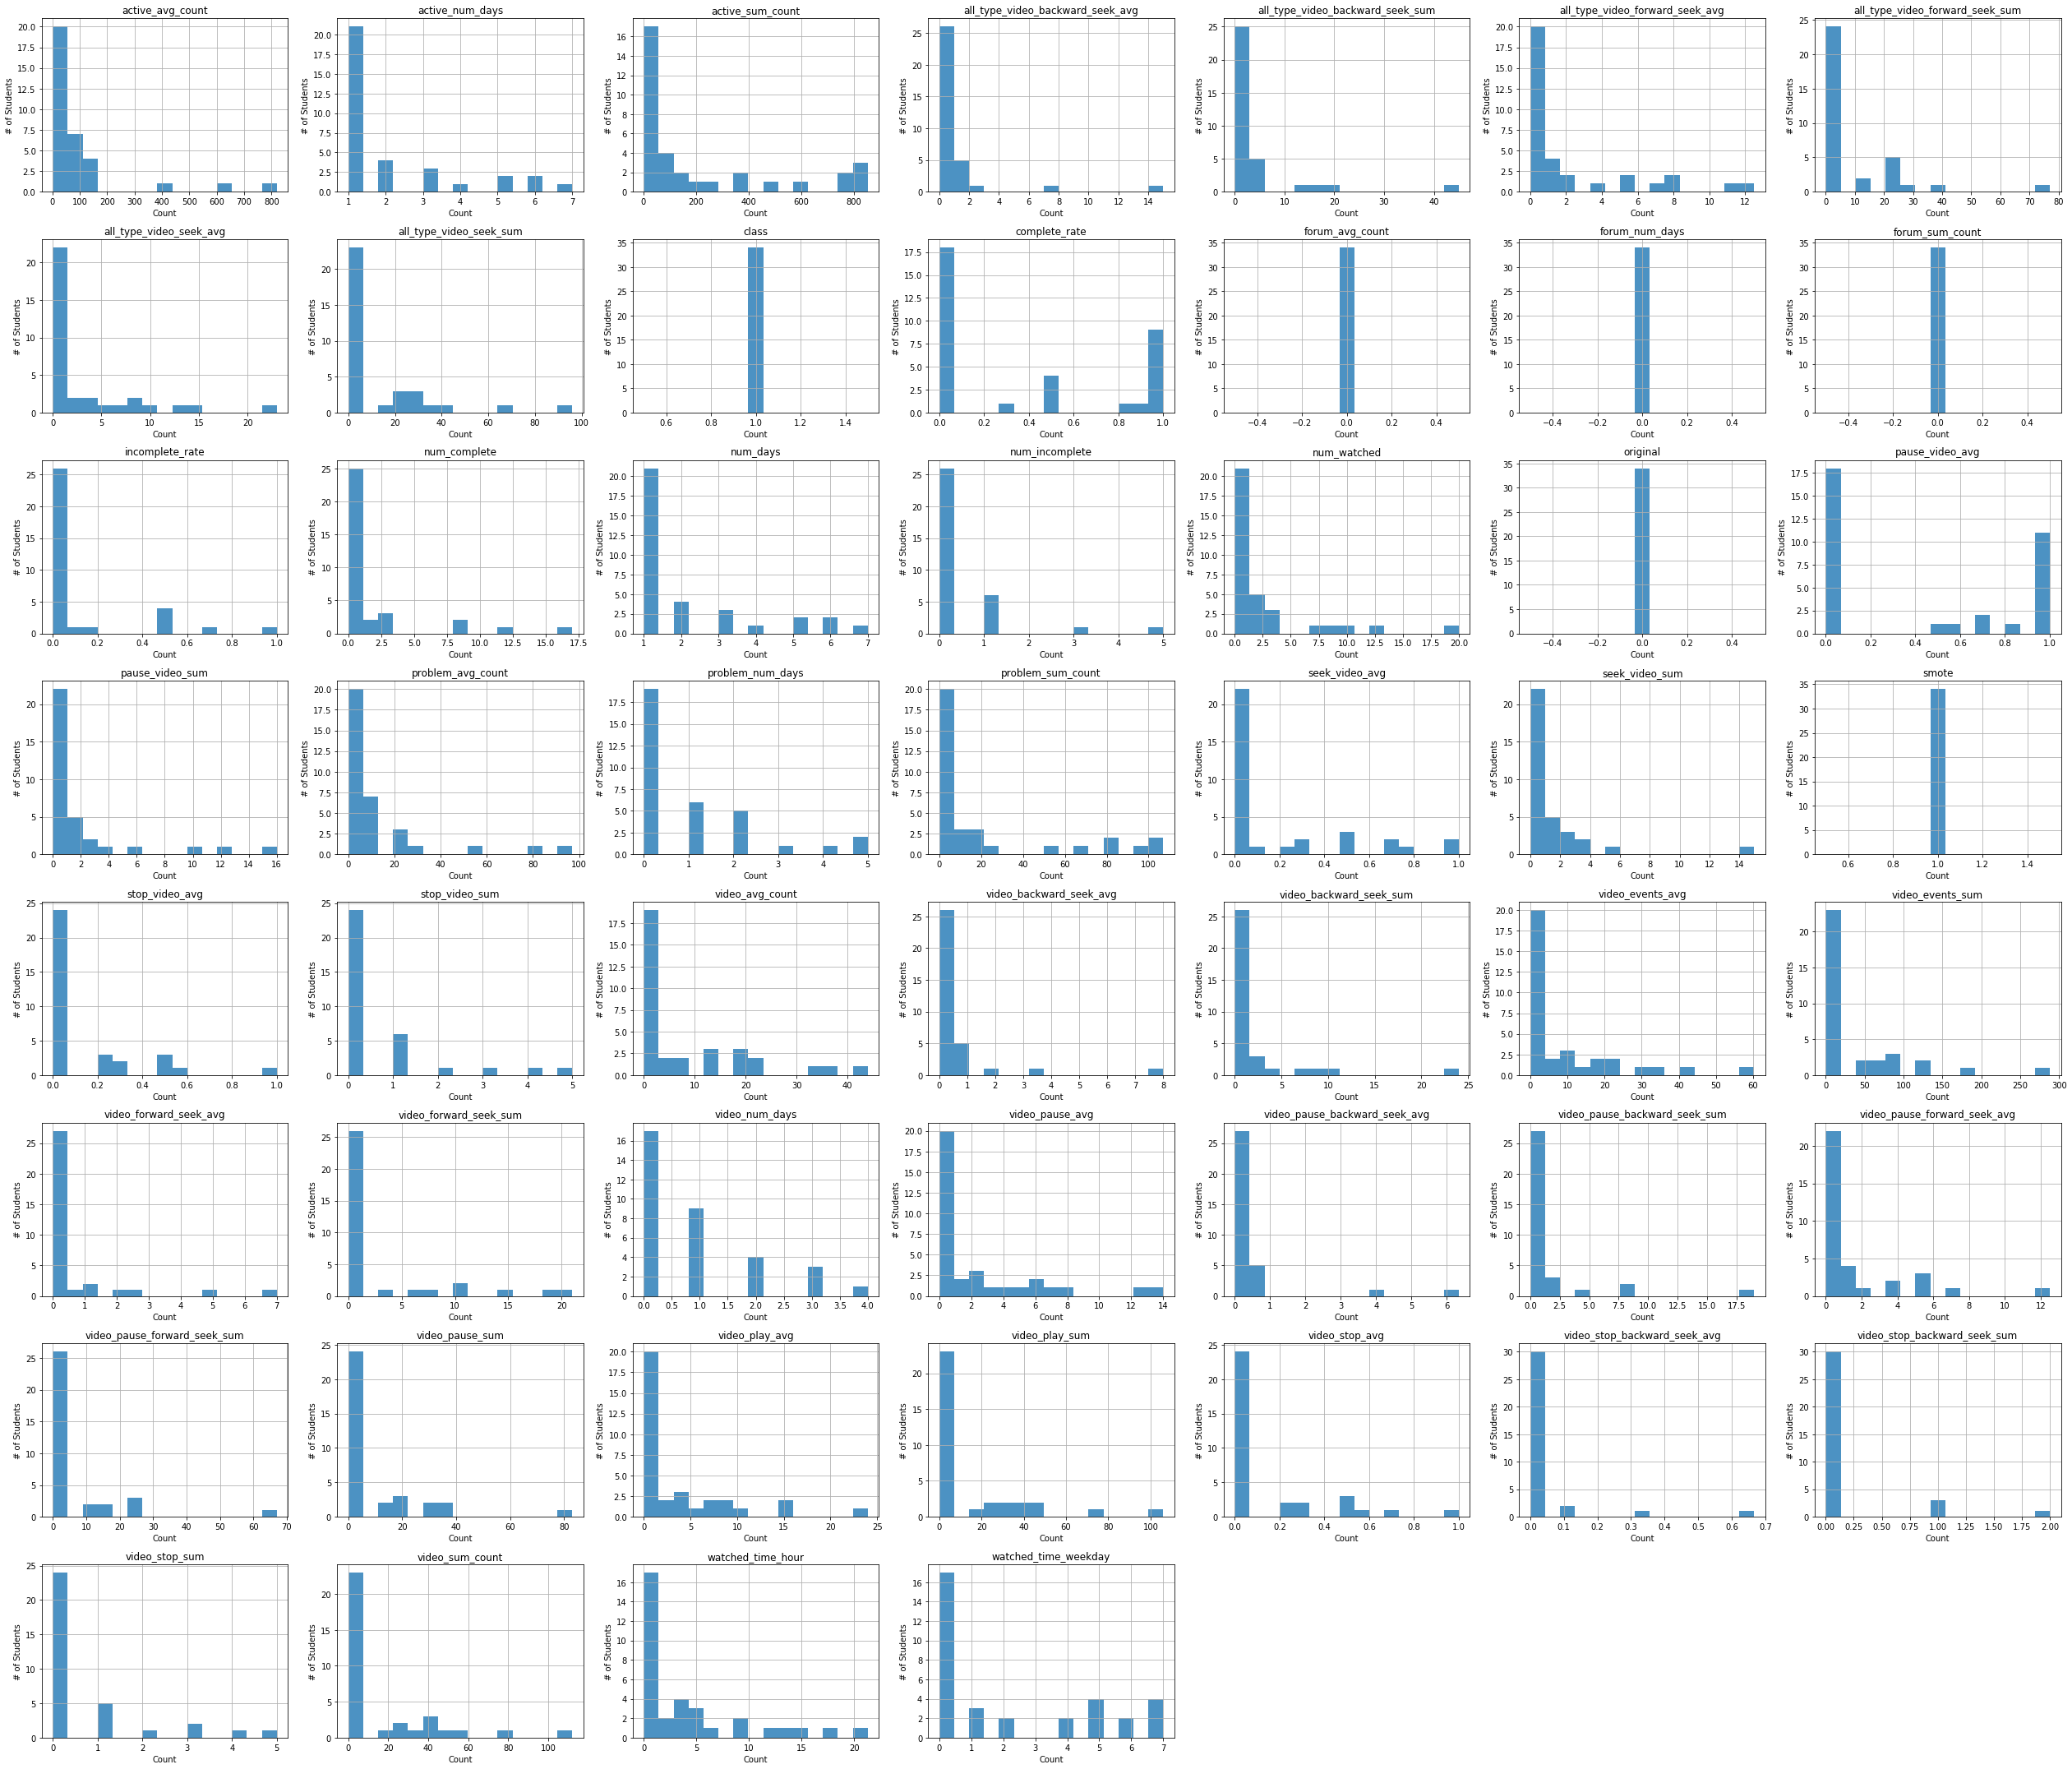

In [46]:
plt.figure(figsize=(35, 35))
ax = smote_pd.hist(alpha=0.8, bins=15, figsize=(35, 30))

for array in ax:
    for subplot in array:
        subplot.set_ylabel('# of Students')
        subplot.set_xlabel('Count')

plt.tight_layout()
image_name = './images/' + datasets + '_' + 'fc_smote' + '.png'
plt.savefig(image_name, dpi=300)